In [6]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
100% 120M/121M [00:07<00:00, 20.4MB/s]
100% 121M/121M [00:07<00:00, 17.1MB/s]


In [7]:
! unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [25]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import glob
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from torchvision.datasets import ImageFolder
from torchvision import transforms
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD, Adam
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import load_img


# EDA

#### Visualizing the some sample images in our input data

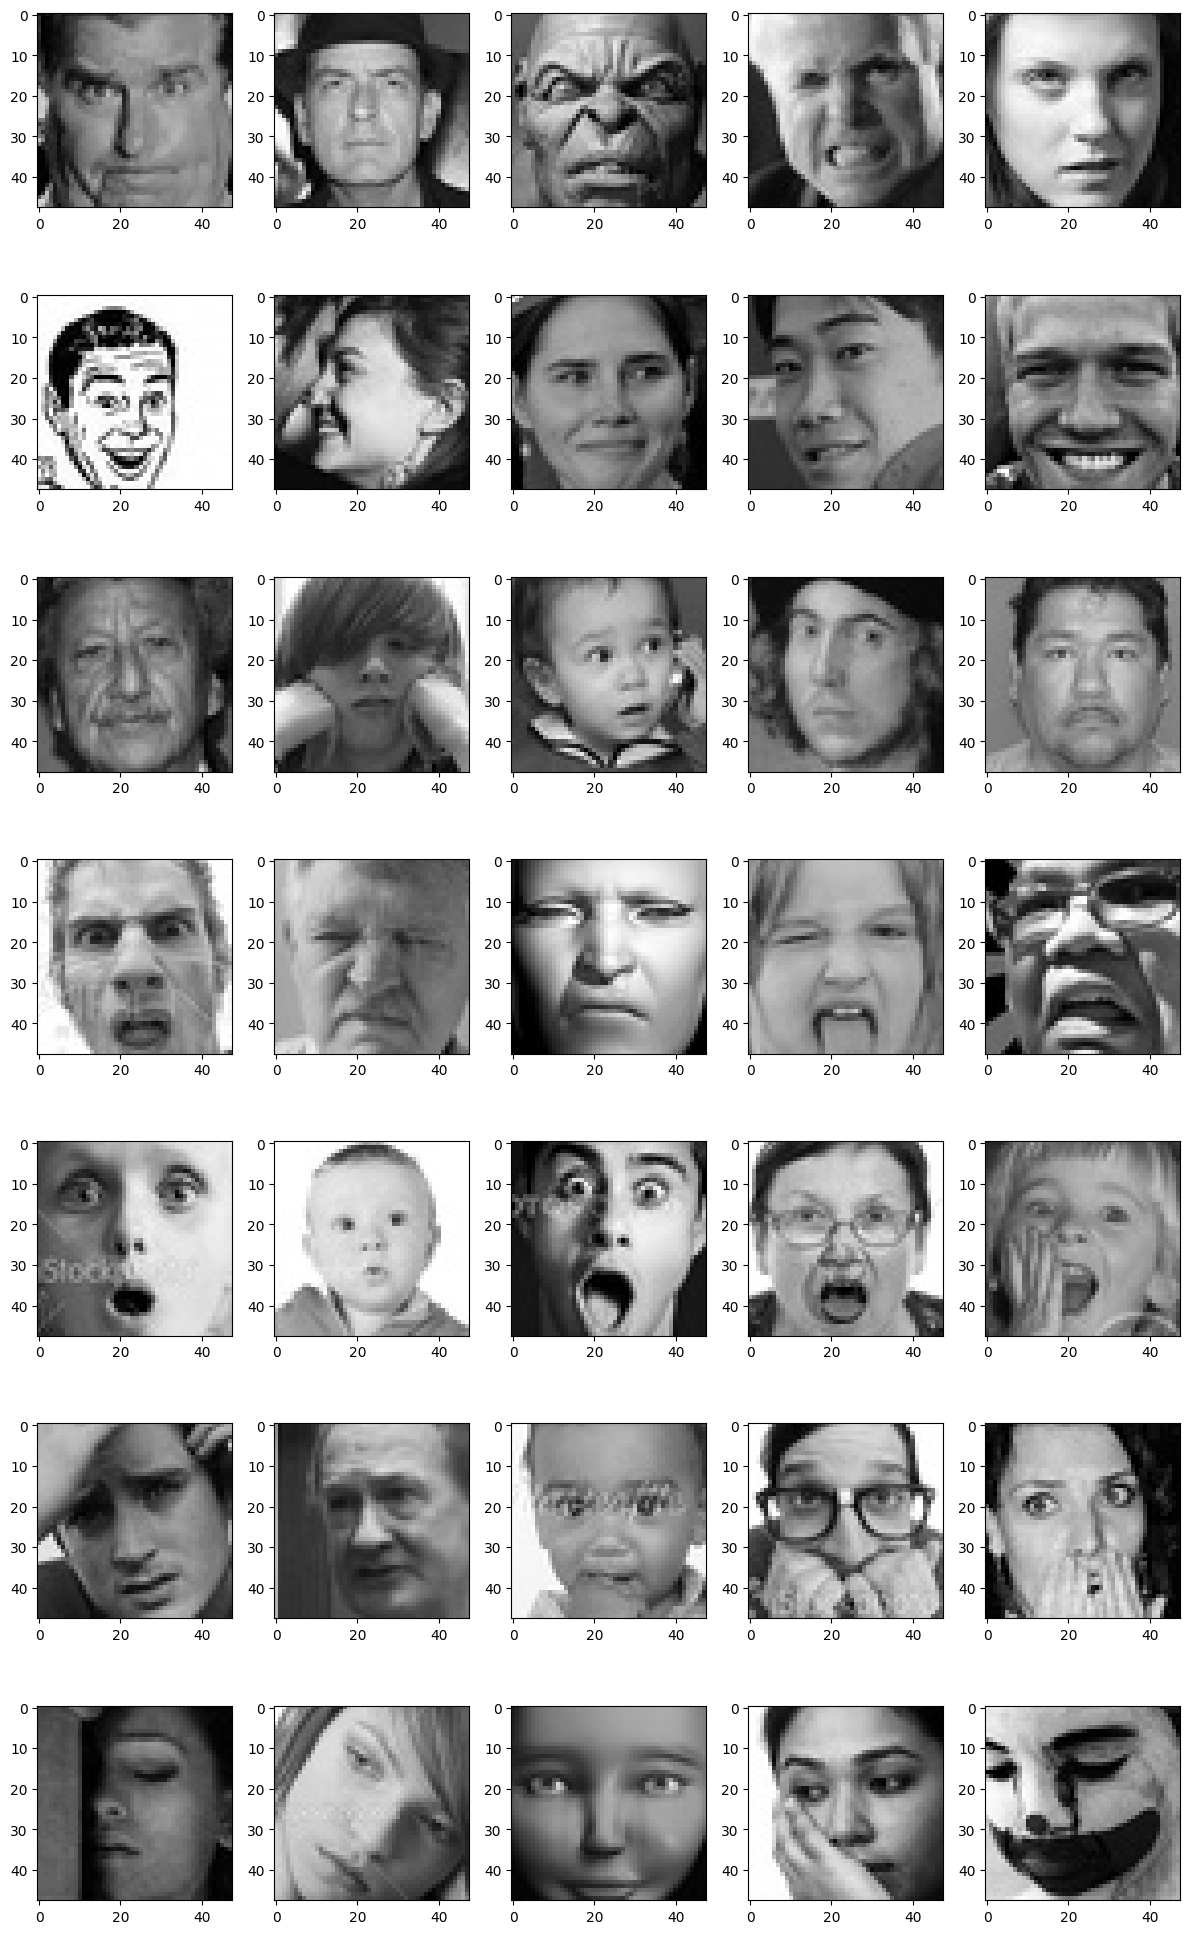

In [9]:
# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = '/content/images/'

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "/train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

#### Finding no. of images in each classes in train and validation set

angry:3993
disgust:436
fear:4103
happy:7164
neutral:4982
sad:4938
surprise:3205
Total number of images: 28821
Class with the maximum number of images: happy(7164)
Class with the minimum number of images: disgust(436)


<Axes: title={'center': 'Bar plot of the number of images in each class'}>

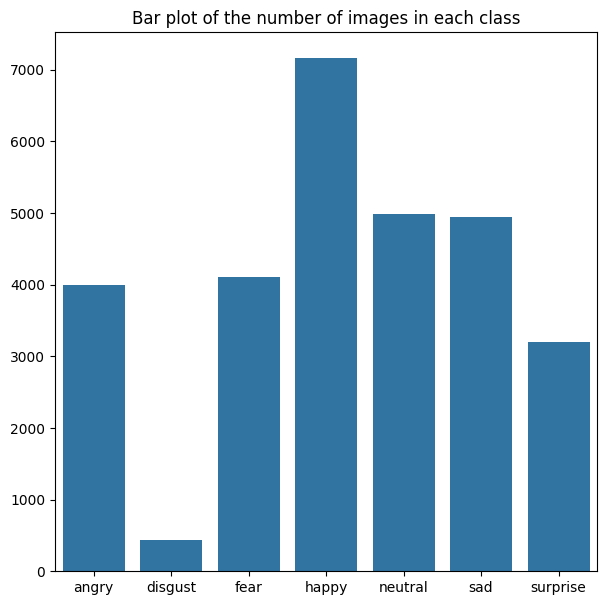

In [10]:
classes = os.listdir(base_path+"/train")
classes

#Calculating the number of images in each class of the training set


transforms_ = transforms.Compose([transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = ImageFolder(base_path+"/train", transform=transforms_)
img, label = trainset[5]


num_classes = 7
class_count = [0] * num_classes
for img, label in trainset:
    class_count[label] += 1

for num, class_lab in zip(class_count, trainset.classes):
    print(f"{class_lab}:{num}")
print(f"Total number of images: {sum(class_count)}")
print(f"Class with the maximum number of images: {trainset.classes[class_count.index(max(class_count))]}({max(class_count)})")
print(f"Class with the minimum number of images: {trainset.classes[class_count.index(min(class_count))]}({min(class_count)})")

plt.figure(figsize=(7,7))
plt.title("Bar plot of the number of images in each class")
sns.barplot(x=trainset.classes, y=class_count)

angry:960
disgust:111
fear:1018
happy:1825
neutral:1216
sad:1139
surprise:797
Total number of images: 7066
Class with the maximum number of images: happy(1825)
Class with the minimum number of images: disgust(111)


<Axes: title={'center': 'Bar plot of the number of images in each class'}>

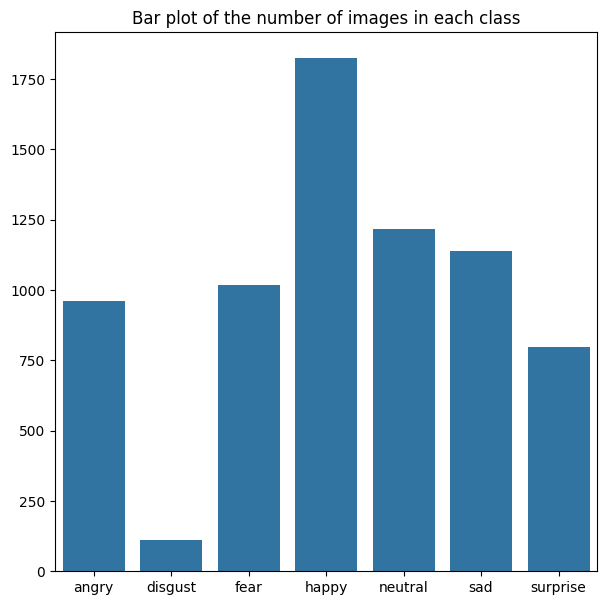

In [11]:
classes = os.listdir(base_path+"/validation")
classes

#Calculating the number of images in each class of the validation set
transforms_ = transforms.Compose([transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = ImageFolder(base_path+"/validation", transform=transforms_)
img, label = trainset[5]


num_classes = 7
class_count = [0] * num_classes
for img, label in trainset:
    class_count[label] += 1

for num, class_lab in zip(class_count, trainset.classes):
    print(f"{class_lab}:{num}")
print(f"Total number of images: {sum(class_count)}")
print(f"Class with the maximum number of images: {trainset.classes[class_count.index(max(class_count))]}({max(class_count)})")
print(f"Class with the minimum number of images: {trainset.classes[class_count.index(min(class_count))]}({min(class_count)})")

plt.figure(figsize=(7,7))
plt.title("Bar plot of the number of images in each class")
sns.barplot(x=trainset.classes, y=class_count)

 ### From the above, we can see that all the image classes in the train and validation are not evenly distributed. Notebly disgust images are the very least.

# Data Preprocessing

In [12]:
# re-size all the images to (224,224) because we are going to use VGG-19 pretrained model where their input images size was (224,224)
IMAGE_SIZE = [224, 224]

train_path = '/content/images/train'
valid_path = '/content/images/validation'

In [13]:
# VGG-19 were trained in RGB colored images but our input images are greyscale.
# so we need to preprocess our input images.
# Convert grayscale to RGB by repeating the single channel 3 times
def grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Define the input layer with the shape of your grayscale images
input_layer = Input(shape=IMAGE_SIZE + [1])

# Use a Lambda layer to convert the input grayscale images to RGB
rgb_layer = Lambda(grayscale_to_rgb)(input_layer)

In [16]:
# Create the train data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = train_datagen.flow_from_directory(
    '/content/images/train',
    batch_size=32,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode = 'grayscale'
)

Found 28821 images belonging to 7 classes.


In [17]:
# Create the test data generators
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
   '/content/images/validation',
    batch_size=32,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode = 'grayscale'
)

Found 7066 images belonging to 7 classes.


# Implement Transfer Learning Technique

##### Remove top layers of VGG-19 because we need to classify 7 different classes. so that we need to remove top layers and modify it according to our requirement. Since it is pretrained model, we dont need to train all the layers except last few modified layers. Should add Batch normalization and L2 regularization when contructing the final layers, it will prevent overfitting and improve model generalization.

In [18]:
# pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=rgb_layer)

80134624/80134624 [==============================] - 4s 0us/step


In [19]:
# Freeze all layers except for the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [20]:
# Add new classification layers on top of the pre-trained layers
num_classes = 7
x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [21]:
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

##### Adjusting learning rate dynamically during training proces, so that it will find better local minimum and prevents overfitting. Asking model to stop training by defining "early_stopping" when val_loss does not improve in 10 consective times. Asking model to save its best variant during the training process. All these will prevent overfitting in the training process.

In [23]:
# Define the learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    os.path.join("/content/model/", "model_28_.h5"),
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [29]:
# It shows overall architecture of our edited pretrained model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

# Model Training

In [30]:

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
900/900 [==============================] - ETA: 0s - loss: 5.9272 - accuracy: 0.2395
Epoch 1: val_accuracy improved from -inf to 0.27401, saving model to /content/model/model_28_.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/900 [==============================] - 150s 153ms/step - loss: 5.9272 - accuracy: 0.2395 - val_loss: 6.0889 - val_accuracy: 0.2740 - lr: 1.0000e-04
Epoch 2/50
900/900 [==============================] - ETA: 0s - loss: 4.0150 - accuracy: 0.3143
Epoch 2: val_accuracy improved from 0.27401 to 0.45881, saving model to /content/model/model_28_.h5
900/900 [==============================] - 135s 150ms/step - loss: 4.0150 - accuracy: 0.3143 - val_loss: 3.0921 - val_accuracy: 0.4588 - lr: 1.0000e-04
Epoch 3/50
900/900 [==============================] - ETA: 0s - loss: 3.1007 - accuracy: 0.3610
Epoch 3: val_accuracy did not improve from 0.45881
900/900 [==============================] - 134s 149ms/step - loss: 3.1007 - accuracy: 0.3610 - val_loss: 2.6342 - val_accuracy: 0.4436 - lr: 1.0000e-04
Epoch 4/50
900/900 [==============================] - ETA: 0s - loss: 2.5717 - accuracy: 0.3882
Epoch 4: val_accuracy improved from 0.45881 to 0.48551, saving model to /content/model/model_28_.h5
900/9

#**Plotting loss and  accuracy**

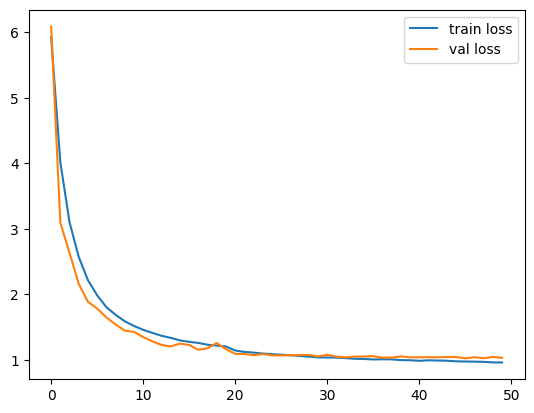

In [32]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

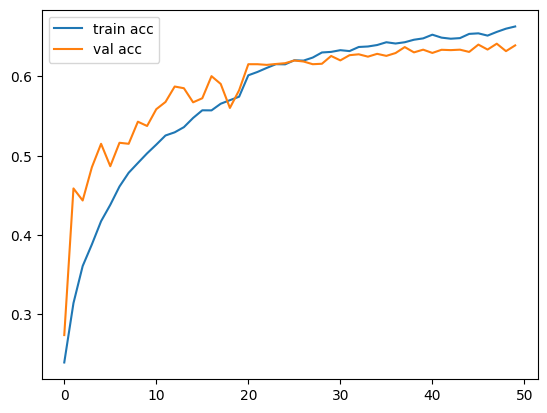

In [33]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### From the above two graph, we can see that the difference between train and validation in both loss and accuracy are very much smaller, so there is no overfitting occurs during training process and found the best result at the same time.

### The best validation accuracy we got is 0.64119. Even though we have used the best pretrained model(VGG19) in our task, we were not able to get higher accuracy. This might be because of unevenly distribution of classes in our dataset.